# SC4020 Project 2 - Task 1
## Analysis of Symptom Co-occurrence Patterns

**Goal**: Using the Apriori algorithm to analyze existing disease symptom datasets, it is often possible to identify common symptom combinations in the same disease.


## 1. Import Necessary Library


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Data Loading

**Note**: Please download the dataset from Kaggle first:

- Dataset link: https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset

- Required file: `dataset.csv` (Main disease-symptom data)

- Place the file in the project root directory

In [3]:
# Load dataset
try:
    df = pd.read_csv('dataset.csv')
    print("Successfully loaded dataset.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv('Disease_Symptom.csv')
        print("Successfully loaded Disease_Symptom.csv")
    except FileNotFoundError:
        print("Error: Data file not found!")
        print("Please download the dataset from:")
        print("https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset")
        df = None

if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst 5 rows:")
    display(df.head())
    print(f"\nColumn names: {df.columns.tolist()}")


Successfully loaded dataset.csv

Dataset shape: (4920, 18)

First 5 rows:


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Column names: ['Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']


## 3. EDA


In [4]:
if df is not None:
    # Basic information
    print("=" * 60)
    print("Dataset Basic Information")
    print("=" * 60)
    print(f"Total diseases: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print(f"\nMissing value statistics:")
    print(df.isnull().sum())
    
    # Check unique disease count
    if 'Disease' in df.columns:
        print(f"\nNumber of unique diseases: {df['Disease'].nunique()}")
        print(f"\nDisease list sample:")
        print(df['Disease'].unique()[:10])


Dataset Basic Information
Total diseases: 4920
Number of columns: 18

Missing value statistics:
Disease          0
Symptom_1        0
Symptom_2        0
Symptom_3        0
Symptom_4      348
Symptom_5     1206
Symptom_6     1986
Symptom_7     2652
Symptom_8     2976
Symptom_9     3228
Symptom_10    3408
Symptom_11    3726
Symptom_12    4176
Symptom_13    4416
Symptom_14    4614
Symptom_15    4680
Symptom_16    4728
Symptom_17    4848
dtype: int64

Number of unique diseases: 41

Disease list sample:
['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
 'Peptic ulcer diseae' 'AIDS' 'Diabetes ' 'Gastroenteritis'
 'Bronchial Asthma']


## 4. Data Preprocessing and Cleaning

### 4.1 Data Cleaning and Standardization


In [5]:
def clean_symptom(symptom):
    """
    Clean and standardize symptom names
    - Convert to lowercase
    - Remove leading/trailing whitespace
    - Replace underscores with spaces
    """
    if pd.isna(symptom) or symptom == '':
        return None
    
    symptom = str(symptom).lower().strip()
    symptom = symptom.replace('_', ' ')
    return symptom if symptom else None

# Symptom synonym mapping dictionary
# Based on medical knowledge, map synonym symptoms to standard names
symptom_synonyms = {
    'pyrexia': 'fever',
    'high temperature': 'fever',
    'elevated temperature': 'fever',
    'headache': 'head ache',
    'stomach ache': 'abdominal pain',
    'belly pain': 'abdominal pain',
    'tummy pain': 'abdominal pain',
    'feeling dizzy': 'dizziness',
    'light headed': 'dizziness',
    'difficulty breathing': 'breathlessness',
    'shortness of breath': 'breathlessness',
    'throwing up': 'vomiting',
    'being sick': 'vomiting',
    'loose motions': 'diarrhoea',
    'runny stool': 'diarrhoea',
    'tiredness': 'fatigue',
    'exhaustion': 'fatigue',
    'weakness': 'fatigue',
}

def normalize_symptom(symptom):
    """
    Standardize symptom names using synonym dictionary
    """
    if symptom is None:
        return None
    return symptom_synonyms.get(symptom, symptom)

print("Data cleaning functions defined successfully!")


Data cleaning functions defined successfully!


### 4.2 Convert Data to Transaction Format


In [6]:
def prepare_transactions(df):
    """
    Convert dataset to transaction format
    Each disease as a transaction (basket), symptoms as items
    
    Returns:
    - transactions: list of sets, each set contains all symptoms of a disease
    - disease_names: corresponding list of disease names
    """
    transactions = []
    disease_names = []
    
    # Find symptom columns (assuming first column is Disease, rest are symptoms)
    symptom_columns = [col for col in df.columns if col != 'Disease']
    
    for idx, row in df.iterrows():
        symptoms = set()
        
        # Collect all symptoms for this disease
        for col in symptom_columns:
            symptom = clean_symptom(row[col])
            if symptom:
                # Standardize symptom names
                symptom = normalize_symptom(symptom)
                symptoms.add(symptom)
        
        if symptoms:  # Only add non-empty transactions
            transactions.append(symptoms)
            disease_names.append(row['Disease'] if 'Disease' in row else f"Disease_{idx}")
    
    return transactions, disease_names

if df is not None:
    transactions, disease_names = prepare_transactions(df)
    
    print(f"Total transactions: {len(transactions)}")
    print(f"\nFirst 5 transaction examples:")
    for i in range(min(5, len(transactions))):
        print(f"\n{disease_names[i]}: {transactions[i]}")


Total transactions: 4920

First 5 transaction examples:

Fungal infection: {'dischromic  patches', 'itching', 'nodal skin eruptions', 'skin rash'}

Fungal infection: {'dischromic  patches', 'skin rash', 'nodal skin eruptions'}

Fungal infection: {'dischromic  patches', 'itching', 'nodal skin eruptions'}

Fungal infection: {'dischromic  patches', 'itching', 'skin rash'}

Fungal infection: {'itching', 'nodal skin eruptions', 'skin rash'}


### 4.3 Statistical Analysis


Transaction Statistics
Total unique symptoms: 130
Average symptoms per disease: 7.43
Median symptom count: 6.00
Minimum symptom count: 3
Maximum symptom count: 17


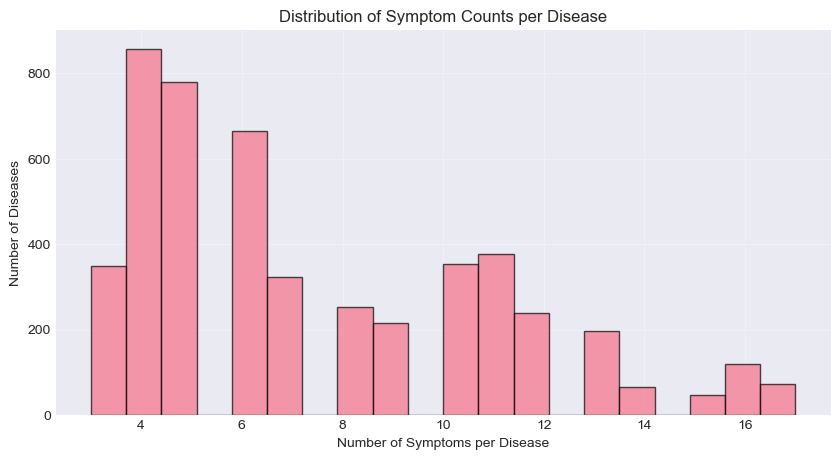


Top 20 most common symptoms:


,Symptom,Count,Support
36,fatigue,1932,0.392683
12,vomiting,1914,0.389024
26,high fever,1362,0.276829
17,loss of appetite,1152,0.234146
18,nausea,1146,0.232927
44,head ache,1134,0.230488
15,abdominal pain,1038,0.210976
16,yellowish skin,912,0.185366
14,yellowing of eyes,816,0.165854
7,chills,798,0.162195


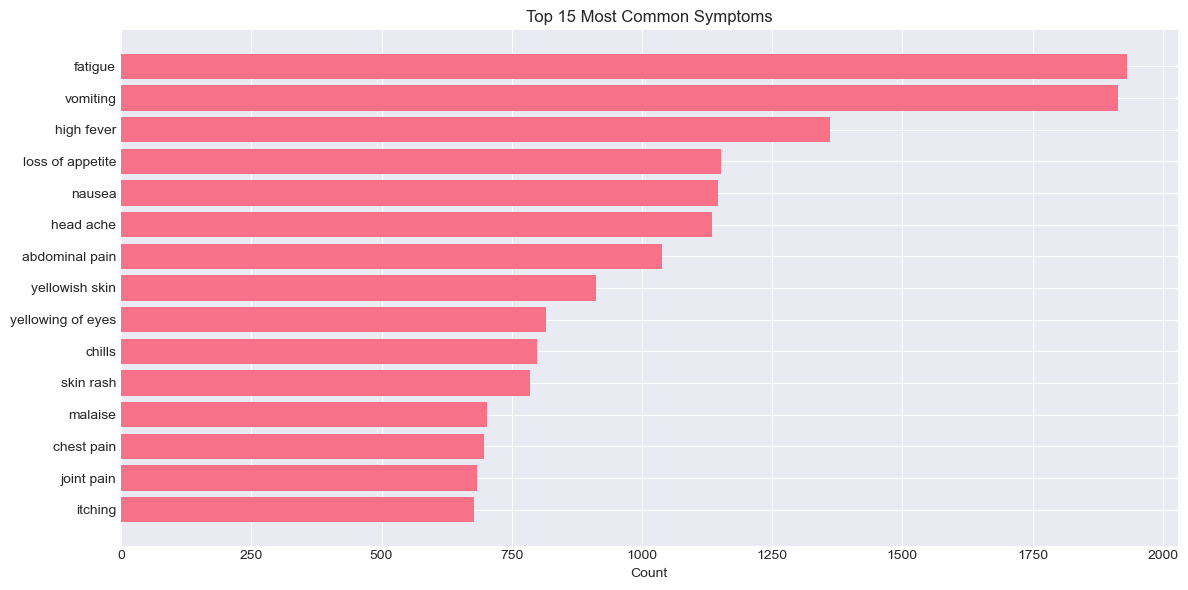

In [7]:
if df is not None:
    # Count all unique symptoms
    all_symptoms = set()
    transaction_lengths = []
    
    for transaction in transactions:
        all_symptoms.update(transaction)
        transaction_lengths.append(len(transaction))
    
    print("=" * 60)
    print("Transaction Statistics")
    print("=" * 60)
    print(f"Total unique symptoms: {len(all_symptoms)}")
    print(f"Average symptoms per disease: {np.mean(transaction_lengths):.2f}")
    print(f"Median symptom count: {np.median(transaction_lengths):.2f}")
    print(f"Minimum symptom count: {np.min(transaction_lengths)}")
    print(f"Maximum symptom count: {np.max(transaction_lengths)}")
    
    # Visualize transaction length distribution
    plt.figure(figsize=(10, 5))
    plt.hist(transaction_lengths, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of Symptoms per Disease')
    plt.ylabel('Number of Diseases')
    plt.title('Distribution of Symptom Counts per Disease')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Count frequency of each symptom
    symptom_counts = defaultdict(int)
    
    for transaction in transactions:
        for symptom in transaction:
            symptom_counts[symptom] += 1
    
    # Convert to DataFrame and sort
    symptom_freq_df = pd.DataFrame([
        {'Symptom': symptom, 'Count': count, 'Support': count/len(transactions)}
        for symptom, count in symptom_counts.items()
    ]).sort_values('Count', ascending=False)
    
    print("\nTop 20 most common symptoms:")
    display(symptom_freq_df.head(20))
    
    # Visualize top 15 most common symptoms
    plt.figure(figsize=(12, 6))
    top_symptoms = symptom_freq_df.head(15)
    plt.barh(range(len(top_symptoms)), top_symptoms['Count'])
    plt.yticks(range(len(top_symptoms)), top_symptoms['Symptom'])
    plt.xlabel('Count')
    plt.title('Top 15 Most Common Symptoms')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


## 5. Apriori Algorithm Implementation

### 5.1 Apriori Core Functions

**Algorithm Reference**: Basic principle of Apriori algorithm (all subsets of frequent itemsets must also be frequent)  
**Code Implementation**: Completely self-written, including candidate generation, pruning, and support calculation


In [8]:
class AprioriAlgorithm:
    """
    Apriori Algorithm Implementation
    for discovering frequent itemsets and association rules
    
    Algorithm references standardAprioriprinciples,code structure and implementation are self-written
    """
    
    def __init__(self, min_support=0.1, min_confidence=0.5):
        """
        Initialization
        
        Parameters:
        - min_support: Minimum support threshold
        - min_confidence: Minimum confidence threshold(for association rules)
        """
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.transactions = []
        self.frequent_itemsets = {}
        self.association_rules = []
    
    def fit(self, transactions):
        """
        Train on transaction data Apriori Algorithm
        
        Parameters:
        - transactions: list of sets, transaction data
        """
        self.transactions = [set(t) for t in transactions]
        self.frequent_itemsets = self._find_frequent_itemsets()
        self.association_rules = self._generate_association_rules()
        return self
    
    def _calculate_support(self, itemset):
        """
        Calculate itemset support
        
        Support = number of transactions containing this itemset / total number of transactions
        """
        itemset = frozenset(itemset)
        count = sum(1 for transaction in self.transactions if itemset.issubset(transaction))
        return count / len(self.transactions)
    
    def _get_frequent_1_itemsets(self):
        """
        Find frequent 1-itemsets
        """
        item_counts = defaultdict(int)
        
        # Count each single item
        for transaction in self.transactions:
            for item in transaction:
                item_counts[frozenset([item])] += 1
        
        # Filter items meeting minimum support
        min_count = self.min_support * len(self.transactions)
        frequent_items = {
            itemset: count / len(self.transactions)
            for itemset, count in item_counts.items()
            if count >= min_count
        }
        
        return frequent_items
    
    def _generate_candidates(self, frequent_itemsets_k):
        """
        Generate (k+1)-candidate itemsets from k-itemsets
        using self-join method
        """
        candidates = set()
        itemsets_list = list(frequent_itemsets_k.keys())
        
        for i in range(len(itemsets_list)):
            for j in range(i + 1, len(itemsets_list)):
                # Merge two k-itemsets
                union = itemsets_list[i] | itemsets_list[j]
                
                # If merged size is k+1, then it is a valid candidate
                if len(union) == len(itemsets_list[i]) + 1:
                    candidates.add(union)
        
        return candidates
    
    def _prune_candidates(self, candidates, frequent_itemsets_k):
        """
        Pruning: Remove candidate itemsets whose subsets are not frequent
        """
        pruned = set()
        
        for candidate in candidates:
            # Check all k-subsets are frequent
            subsets = [frozenset(s) for s in combinations(candidate, len(candidate) - 1)]
            
            if all(subset in frequent_itemsets_k for subset in subsets):
                pruned.add(candidate)
        
        return pruned
    
    def _find_frequent_itemsets(self):
        """
        Find all frequent itemsets
        
        Returns:
        - dict: {k: {itemset: support}}, k is itemset size
        """
        all_frequent_itemsets = {}
        
        # Find frequent 1-itemsets
        frequent_1 = self._get_frequent_1_itemsets()
        if not frequent_1:
            return all_frequent_itemsets
        
        all_frequent_itemsets[1] = frequent_1
        k = 1
        
        # Iteratively generate largerfrequent itemsets
        while True:
            # Generate candidate itemsets
            candidates = self._generate_candidates(all_frequent_itemsets[k])
            
            if not candidates:
                break
            
            # Pruning
            candidates = self._prune_candidates(candidates, all_frequent_itemsets[k])
            
            if not candidates:
                break
            
            # Calculate support for candidate itemsets
            frequent_k_plus_1 = {}
            for candidate in candidates:
                support = self._calculate_support(candidate)
                if support >= self.min_support:
                    frequent_k_plus_1[candidate] = support
            
            if not frequent_k_plus_1:
                break
            
            k += 1
            all_frequent_itemsets[k] = frequent_k_plus_1
        
        return all_frequent_itemsets
    
    def _generate_association_rules(self):
        """
        Generate association rules from frequent itemsets
        
        Association rule form: A -> B
        Confidence = support(A ∪ B) / support(A)
        Lift = confidence / support(B)
        """
        rules = []
        
        # Start generating rules from 2-itemsets
        for k in range(2, max(self.frequent_itemsets.keys()) + 1):
            for itemset, support in self.frequent_itemsets[k].items():
                # Generate all non-empty proper subsets as antecedents
                for i in range(1, len(itemset)):
                    for antecedent in combinations(itemset, i):
                        antecedent = frozenset(antecedent)
                        consequent = itemset - antecedent
                        
                        # Calculate confidence
                        antecedent_support = self._get_support(antecedent)
                        if antecedent_support > 0:
                            confidence = support / antecedent_support
                            
                            if confidence >= self.min_confidence:
                                # Calculate lift
                                consequent_support = self._get_support(consequent)
                                lift = confidence / consequent_support if consequent_support > 0 else 0
                                
                                rules.append({
                                    'antecedent': antecedent,
                                    'consequent': consequent,
                                    'support': support,
                                    'confidence': confidence,
                                    'lift': lift
                                })
        
        return rules
    
    def _get_support(self, itemset):
        """
        Get support for itemset
        """
        itemset = frozenset(itemset)
        k = len(itemset)
        
        if k in self.frequent_itemsets and itemset in self.frequent_itemsets[k]:
            return self.frequent_itemsets[k][itemset]
        else:
            return self._calculate_support(itemset)
    
    def get_frequent_itemsets_df(self):
        """
        Convert frequent itemsets to DataFrame format
        """
        data = []
        for k, itemsets in self.frequent_itemsets.items():
            for itemset, support in itemsets.items():
                data.append({
                    'Itemset Size': k,
                    'itemsets': set(itemset),
                    'Support': support,
                    'Count': int(support * len(self.transactions))
                })
        
        # If no data, return empty DataFrame with column names
        if not data:
            return pd.DataFrame(columns=['itemsetsize', 'itemset', 'Support', 'Count'])
        
        return pd.DataFrame(data).sort_values(['Itemset Size', 'Support'], ascending=[True, False])
    
    def get_association_rules_df(self):
        """
        Convert association rules to DataFrame format
        """
        data = []
        for rule in self.association_rules:
            data.append({
                'Antecedent': set(rule['antecedent']),
                'Consequent': set(rule['consequent']),
                'Support': rule['support'],
                'Confidence': rule['confidence'],
                'Lift': rule['lift']
            })
        
        # If no data, return empty DataFrame with column names
        if not data:
            return pd.DataFrame(columns=['Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift'])
        
        return pd.DataFrame(data).sort_values('Lift', ascending=False)

print("Apriori Algorithm class defined successfully!")


Apriori Algorithm class defined successfully!


### 5.2 Run Apriori Algorithm


In [9]:
# Set parameters
MIN_SUPPORT = 0.05  # Minimum Support 5%
MIN_CONFIDENCE = 0.6  # Minimum Confidence 60%

if df is not None:
    print("Starting to run Apriori Algorithm...")
    print(f"Minimum Support: {MIN_SUPPORT}")
    print(f"Minimum Confidence: {MIN_CONFIDENCE}")
    print(f"Number of transactions: {len(transactions)}")
    print("\nThis may take a few minutes, please wait patiently...\n")
    
    # Create and train model
    apriori = AprioriAlgorithm(min_support=MIN_SUPPORT, min_confidence=MIN_CONFIDENCE)
    apriori.fit(transactions)
    
    print("✓ Apriori AlgorithmRun completed successfully!")


Starting to run Apriori Algorithm...
Minimum Support: 0.05
Minimum Confidence: 0.6
Number of transactions: 4920

This may take a few minutes, please wait patiently...

✓ Apriori AlgorithmRun completed successfully!


## 6. Results Analysis

### 6.1 Frequent Itemsets Analysis


In [10]:
if df is not None:
    # GetFrequent Itemsets
    frequent_itemsets_df = apriori.get_frequent_itemsets_df()
    
    print("=" * 60)
    print("Frequent ItemsetsStatistics")
    print("=" * 60)
    
    # Statistics by Itemset Size
    size_counts = frequent_itemsets_df['Itemset Size'].value_counts().sort_index()
    print("\nEach sizeFrequent Itemsetscount:")
    for size, count in size_counts.items():
        print(f"  {size}-itemsets: {count} items")
    
    print(f"\ntotalFrequent Itemsetscount: {len(frequent_itemsets_df)}")
    
    # Display frequent1-itemsets(Most common individual symptoms)
    print("\n" + "=" * 60)
    print("Frequent 1-itemsets (Most common individual symptoms)")
    print("=" * 60)
    frequent_1 = frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 1].head(20)
    display(frequent_1)


Frequent ItemsetsStatistics

Each sizeFrequent Itemsetscount:
  1-itemsets: 31 items
  2-itemsets: 104 items
  3-itemsets: 153 items
  4-itemsets: 143 items
  5-itemsets: 86 items
  6-itemsets: 36 items
  7-itemsets: 9 items

totalFrequent Itemsetscount: 562

Frequent 1-itemsets (Most common individual symptoms)


,Itemset Size,itemsets,Support,Count
15,1,{fatigue},0.392683,1932
4,1,{vomiting},0.389024,1914
11,1,{high fever},0.276829,1362
9,1,{loss of appetite},0.234146,1152
10,1,{nausea},0.232927,1146
21,1,{head ache},0.230488,1134
8,1,{abdominal pain},0.210976,1038
7,1,{yellowish skin},0.185366,912
6,1,{yellowing of eyes},0.165854,816
2,1,{chills},0.162195,798


In [11]:
if df is not None:
    # Display frequent 2-itemsets (Most common Symptom pairs)
    print("\n" + "=" * 60)
    print("Frequent 2-itemsets (Most common Symptom combinations)")
    print("=" * 60)
    frequent_2 = frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 2].head(30)
    if len(frequent_2) > 0:
        display(frequent_2)
    else:
        print("Frequent itemsets not found2-itemsets,Recommend loweringMinimum Supportthreshold")



Frequent 2-itemsets (Most common Symptom combinations)


,Itemset Size,itemsets,Support,Count
54,2,"{vomiting, nausea}",0.198780,978
86,2,"{fatigue, high fever}",0.198780,978
65,2,"{vomiting, abdominal pain}",0.178049,876
31,2,"{yellowing of eyes, loss of appetite}",0.159756,786
78,2,"{fatigue, loss of appetite}",0.157317,774
81,2,"{vomiting, loss of appetite}",0.156098,768
108,2,"{yellowish skin, abdominal pain}",0.154878,762
113,2,"{vomiting, fatigue}",0.154878,762
61,2,"{nausea, loss of appetite}",0.135366,666
117,2,"{malaise, fatigue}",0.135366,666


In [12]:
if df is not None:
    # Display frequent 3-itemsets and larger itemsets
    print("\n" + "=" * 60)
    print("Frequent 3-itemsets and larger itemsets")
    print("=" * 60)
    frequent_3plus = frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] >= 3].head(30)
    if len(frequent_3plus) > 0:
        display(frequent_3plus)
    else:
        print("Frequent itemsets not found3-itemsetsor larger itemsets")



Frequent 3-itemsets and larger itemsets


,Itemset Size,itemsets,Support,Count
223,3,"{yellowish skin, yellowing of eyes, loss of ap...",0.128049,630
163,3,"{vomiting, yellowish skin, abdominal pain}",0.125610,618
207,3,"{vomiting, yellowing of eyes, loss of appetite}",0.109756,540
228,3,"{yellowing of eyes, abdominal pain, loss of ap...",0.109756,540
160,3,"{yellowish skin, yellowing of eyes, abdominal ...",0.108537,534
248,3,"{fatigue, yellowing of eyes, loss of appetite}",0.108537,534
167,3,"{fatigue, high fever, chills}",0.107317,528
255,3,"{vomiting, nausea, loss of appetite}",0.107317,528
142,3,"{yellowish skin, abdominal pain, loss of appet...",0.106098,522
147,3,"{malaise, fatigue, high fever}",0.106098,522


### 6.2 VisualizationFrequent Itemsets


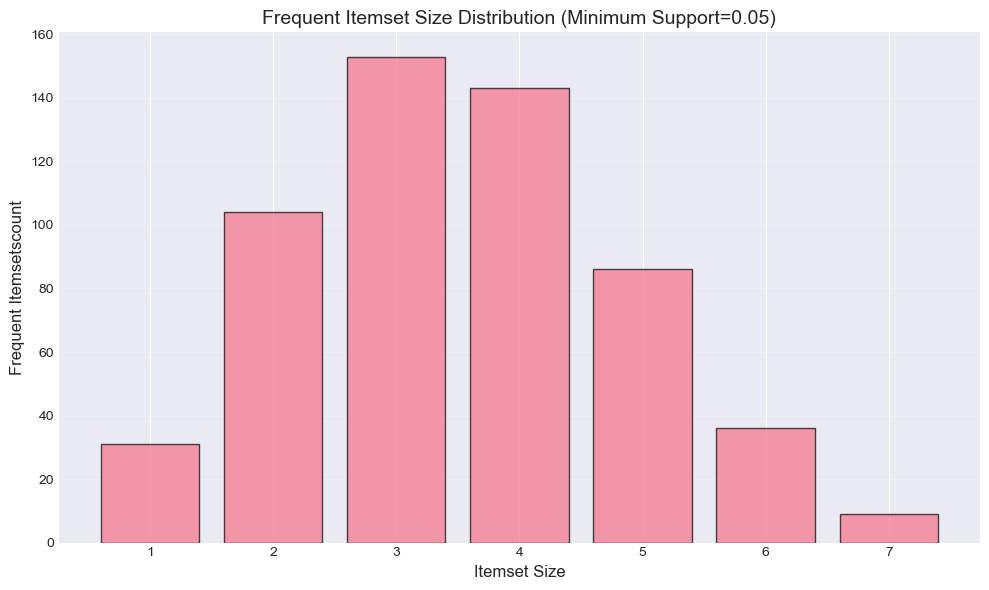

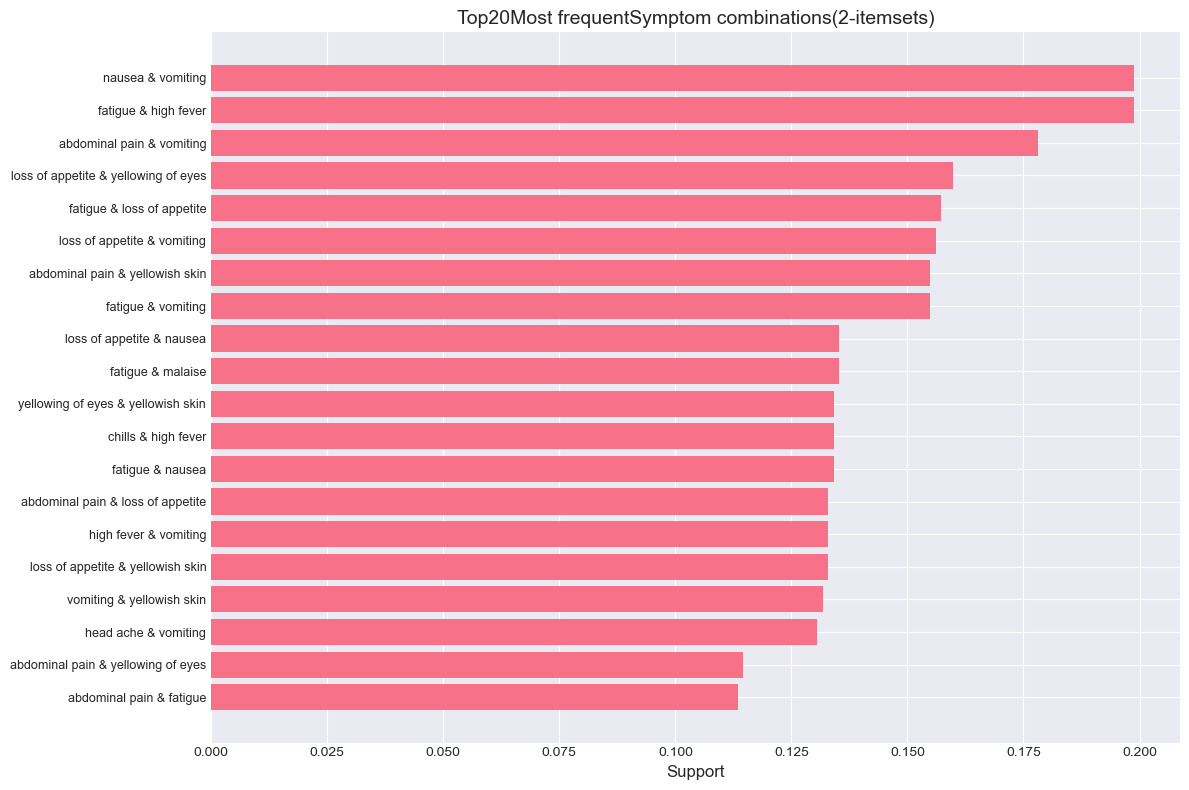

In [13]:
if df is not None:
    # visualized:Each sizeFrequent Itemsetscount
    size_counts = frequent_itemsets_df['Itemset Size'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(size_counts.index, size_counts.values, edgecolor='black', alpha=0.7)
    plt.xlabel('Itemset Size', fontsize=12)
    plt.ylabel('Frequent Itemsetscount', fontsize=12)
    plt.title(f'Frequent Itemset Size Distribution (Minimum Support={MIN_SUPPORT})', fontsize=14)
    plt.xticks(size_counts.index)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Visualization: Top20Most frequent2-itemsets
    if len(frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 2]) > 0:
        frequent_2 = frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 2].head(20)
        
        plt.figure(figsize=(12, 8))
        
        # Create labels
        labels = [' & '.join(sorted(list(itemset))) for itemset in frequent_2['itemsets']]
        
        plt.barh(range(len(frequent_2)), frequent_2['Support'])
        plt.yticks(range(len(frequent_2)), labels, fontsize=9)
        plt.xlabel('Support', fontsize=12)
        plt.title('Top20Most frequentSymptom combinations(2-itemsets)', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


### 6.3 Association Rules Analysis


In [14]:
if df is not None:
    # Getassociation rules
    association_rules_df = apriori.get_association_rules_df()
    
    print("=" * 60)
    print("Association Rules Analysis")
    print("=" * 60)
    print(f"\ndiscoveredNumber of association rules: {len(association_rules_df)}")
    
    if len(association_rules_df) > 0:
        print(f"\nTop 20 Strongest Association Rules (sorted by Lift):")
        display(association_rules_df.head(20))
        
        print("\n" + "=" * 60)
        print("Top20High Confidence Association Rules")
        print("=" * 60)
        top_confidence = association_rules_df.sort_values('Confidence', ascending=False).head(20)
        display(top_confidence)
    else:
        print("\nNo association rules found meeting the criteria, recommend lowering minimum confidence threshold")


Association Rules Analysis

discoveredNumber of association rules: 5458

Top 20 Strongest Association Rules (sorted by Lift):


,Antecedent,Consequent,Support,Confidence,Lift
68,{phlegm},"{malaise, chest pain}",0.069512,0.966102,13.658679
70,"{malaise, chest pain}",{phlegm},0.069512,0.982759,13.658679
429,{phlegm},"{fatigue, chest pain}",0.068293,0.949153,13.654475
93,{phlegm},"{chills, chest pain}",0.068293,0.949153,13.654475
96,"{chills, chest pain}",{phlegm},0.068293,0.982456,13.654475
220,"{high fever, chest pain}",{phlegm},0.068293,0.982456,13.654475
217,{phlegm},"{high fever, chest pain}",0.068293,0.949153,13.654475
432,"{fatigue, chest pain}",{phlegm},0.068293,0.982456,13.654475
1396,"{malaise, cough}","{phlegm, chest pain}",0.065854,0.981818,13.645609
1406,{phlegm},"{malaise, chills, chest pain}",0.065854,0.915254,13.645609



Top20High Confidence Association Rules


,Antecedent,Consequent,Support,Confidence,Lift
69,"{malaise, phlegm}",{chest pain},0.069512,1.0,7.068966
802,"{phlegm, cough, high fever}",{chest pain},0.064634,1.0,7.068966
2826,"{phlegm, cough, fatigue, high fever}",{chest pain},0.060976,1.0,7.068966
2383,"{malaise, cough, high fever, phlegm}",{chest pain},0.062195,1.0,7.068966
1085,"{phlegm, cough, fatigue}",{chest pain},0.064634,1.0,7.068966
2407,"{malaise, high fever, phlegm, chills}",{chest pain},0.062195,1.0,7.068966
4251,"{malaise, cough, phlegm, high fever, chills}",{chest pain},0.058537,1.0,7.068966
1437,"{malaise, high fever, phlegm}",{chest pain},0.065854,1.0,7.068966
1095,"{phlegm, fatigue, chills}",{chest pain},0.064634,1.0,7.068966
1203,"{phlegm, cough, chills}",{chest pain},0.064634,1.0,7.068966


### 6.4 Visualizationassociation rules


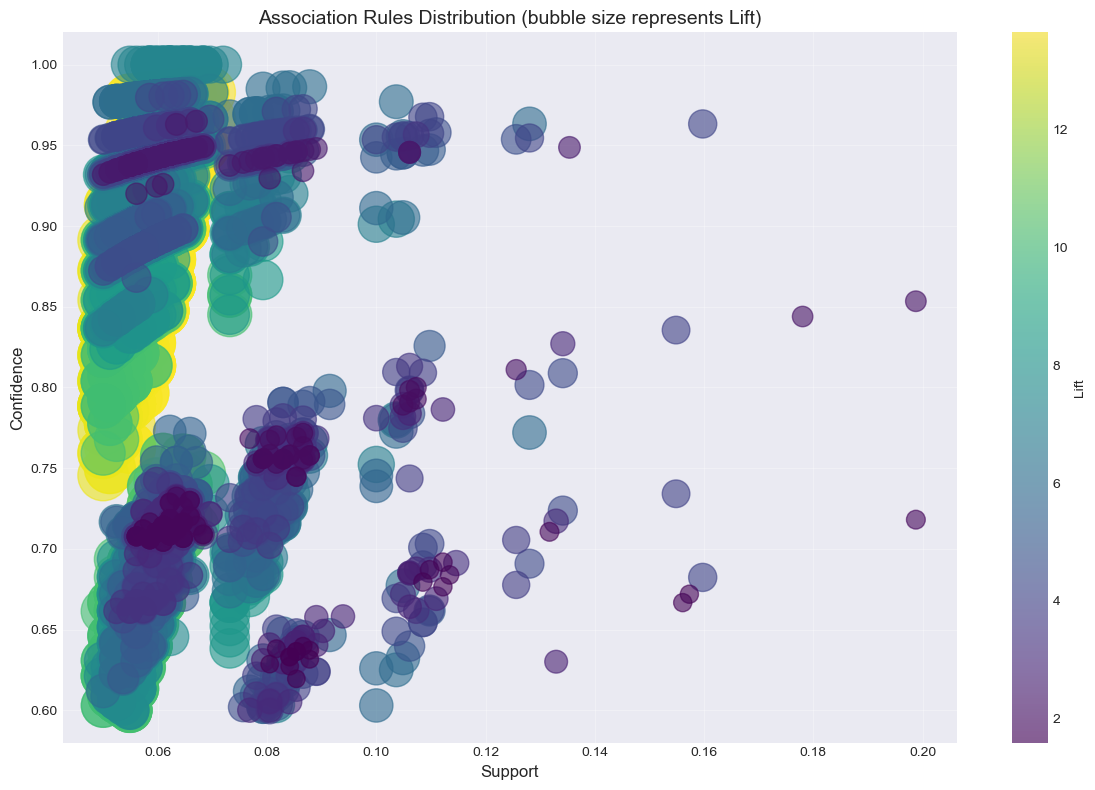

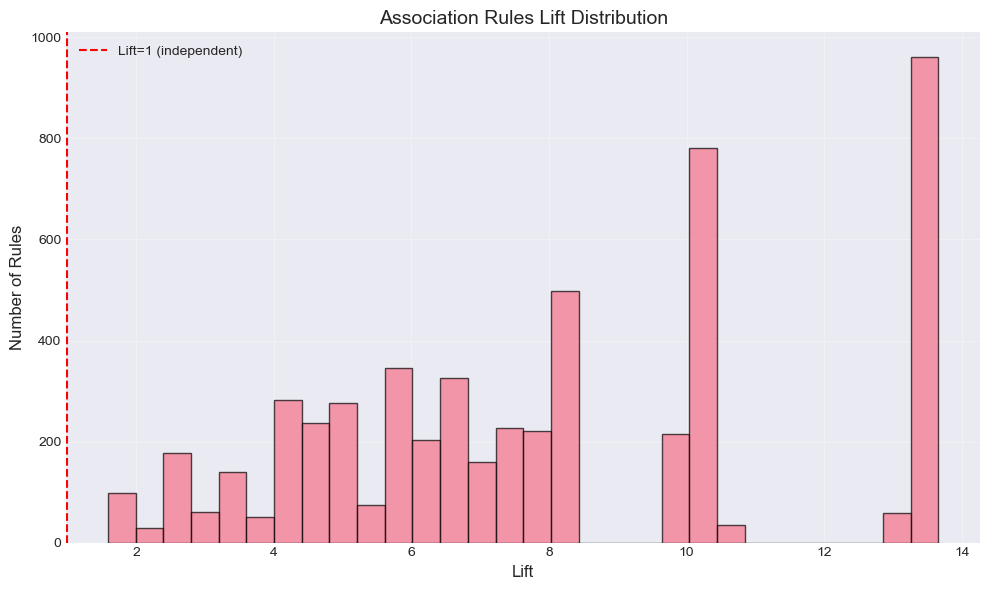

In [15]:
if df is not None and len(association_rules_df) > 0:
    # Scatter plot: Support vs Confidence, bubble size represents Lift
    plt.figure(figsize=(12, 8))
    
    scatter = plt.scatter(
        association_rules_df['Support'],
        association_rules_df['Confidence'],
        s=association_rules_df['Lift'] * 100,
        alpha=0.6,
        c=association_rules_df['Lift'],
        cmap='viridis'
    )
    
    plt.colorbar(scatter, label='Lift')
    plt.xlabel('Support', fontsize=12)
    plt.ylabel('Confidence', fontsize=12)
    plt.title('Association Rules Distribution (bubble size represents Lift)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # LiftDistribution
    plt.figure(figsize=(10, 6))
    plt.hist(association_rules_df['Lift'], bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Lift', fontsize=12)
    plt.ylabel('Number of Rules', fontsize=12)
    plt.title('Association Rules Lift Distribution', fontsize=14)
    plt.axvline(x=1, color='red', linestyle='--', label='Lift=1 (independent)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## 7. Sensitivity Analysis

Testing the impact of different minimum support thresholds on results


In [16]:
if df is not None:
    # Testing different support thresholds
    support_thresholds = [0.02, 0.05, 0.1, 0.15, 0.2]
    sensitivity_results = []
    
    print("Starting sensitivity analysis...")
    print("Testing different minimum support thresholds\n")
    
    for min_sup in support_thresholds:
        print(f"Testing Minimum Support = {min_sup}...")
        
        apriori_temp = AprioriAlgorithm(min_support=min_sup, min_confidence=MIN_CONFIDENCE)
        apriori_temp.fit(transactions)
        
        # Statistics results
        freq_df = apriori_temp.get_frequent_itemsets_df()
        rules_df = apriori_temp.get_association_rules_df()
        
        # Count itemsets for each size
        size_counts_dict = freq_df['Itemset Size'].value_counts().to_dict()
        
        sensitivity_results.append({
            'Minimum Support': min_sup,
            'Total Frequent Itemsets': len(freq_df),
            '1-itemsetscount': size_counts_dict.get(1, 0),
            '2-itemsetscount': size_counts_dict.get(2, 0),
            '3-itemsetscount': size_counts_dict.get(3, 0),
            'Number of association rules': len(rules_df)
        })
    
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    print("\n" + "=" * 60)
    print("Sensitivity Analysis Results")
    print("=" * 60)
    display(sensitivity_df)


Starting sensitivity analysis...
Testing different minimum support thresholds

Testing Minimum Support = 0.02...
Testing Minimum Support = 0.05...
Testing Minimum Support = 0.1...
Testing Minimum Support = 0.15...
Testing Minimum Support = 0.2...

Sensitivity Analysis Results


,Minimum Support,Total Frequent Itemsets,1-itemsetscount,2-itemsetscount,3-itemsetscount,Number of association rules
0,0.02,88390,130,894,3368,14305858
1,0.05,562,31,104,153,5458
2,0.10,73,19,33,19,106
3,0.15,19,11,8,0,9
4,0.20,7,7,0,0,0


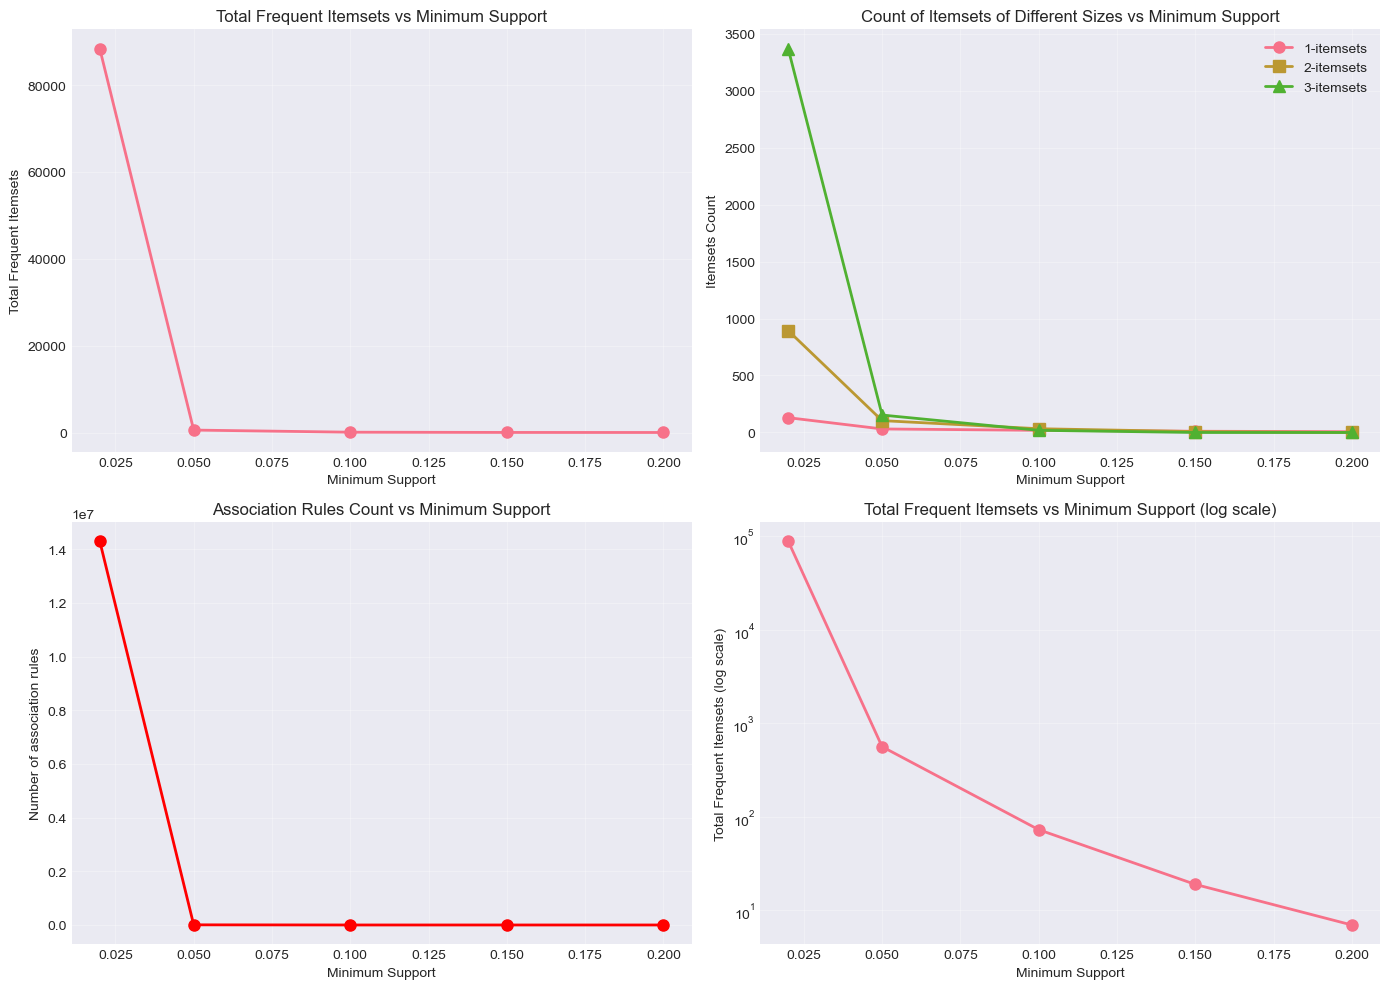

In [17]:
if df is not None:
    # Visualize Sensitivity Analysis Results
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total Frequent Itemsets
    axes[0, 0].plot(sensitivity_df['Minimum Support'], sensitivity_df['Total Frequent Itemsets'], 
                    marker='o', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Minimum Support')
    axes[0, 0].set_ylabel('Total Frequent Itemsets')
    axes[0, 0].set_title('Total Frequent Itemsets vs Minimum Support')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Itemsets count by size
    axes[0, 1].plot(sensitivity_df['Minimum Support'], sensitivity_df['1-itemsetscount'], 
                    marker='o', label='1-itemsets', linewidth=2, markersize=8)
    axes[0, 1].plot(sensitivity_df['Minimum Support'], sensitivity_df['2-itemsetscount'], 
                    marker='s', label='2-itemsets', linewidth=2, markersize=8)
    axes[0, 1].plot(sensitivity_df['Minimum Support'], sensitivity_df['3-itemsetscount'], 
                    marker='^', label='3-itemsets', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Minimum Support')
    axes[0, 1].set_ylabel('Itemsets Count')
    axes[0, 1].set_title('Count of Itemsets of Different Sizes vs Minimum Support')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Number of association rules
    axes[1, 0].plot(sensitivity_df['Minimum Support'], sensitivity_df['Number of association rules'], 
                    marker='o', color='red', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Minimum Support')
    axes[1, 0].set_ylabel('Number of association rules')
    axes[1, 0].set_title('Association Rules Count vs Minimum Support')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Total Frequent Itemsets (logarithmic scale)
    axes[1, 1].semilogy(sensitivity_df['Minimum Support'], sensitivity_df['Total Frequent Itemsets'], 
                        marker='o', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Minimum Support')
    axes[1, 1].set_ylabel('Total Frequent Itemsets (log scale)')
    axes[1, 1].set_title('Total Frequent Itemsets vs Minimum Support (log scale)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 8. Save Results


In [18]:
if df is not None:
    # saveFrequent Itemsets
    frequent_itemsets_df_save = frequent_itemsets_df.copy()
    frequent_itemsets_df_save['itemsets'] = frequent_itemsets_df_save['itemsets'].apply(lambda x: ', '.join(sorted(list(x))))
    frequent_itemsets_df_save.to_csv('task1_frequent_itemsets.csv', index=False, encoding='utf-8-sig')
    print("✓ Frequent Itemsetssaved to: task1_frequent_itemsets.csv")
    
    # Save association rules
    if len(association_rules_df) > 0:
        association_rules_df_save = association_rules_df.copy()
        association_rules_df_save['Antecedent'] = association_rules_df_save['Antecedent'].apply(lambda x: ', '.join(sorted(list(x))))
        association_rules_df_save['Consequent'] = association_rules_df_save['Consequent'].apply(lambda x: ', '.join(sorted(list(x))))
        association_rules_df_save.to_csv('task1_association_rules.csv', index=False, encoding='utf-8-sig')
        print("✓ association rulessaved to: task1_association_rules.csv")
    
    # saveSensitivity Analysis Results
    sensitivity_df.to_csv('task1_sensitivity_analysis.csv', index=False, encoding='utf-8-sig')
    print("✓ Sensitivity analysis results saved to: task1_sensitivity_analysis.csv")
    
    print("\nAll results saved successfully!")


✓ Frequent Itemsetssaved to: task1_frequent_itemsets.csv
✓ association rulessaved to: task1_association_rules.csv
✓ Sensitivity analysis results saved to: task1_sensitivity_analysis.csv

All results saved successfully!


## 9. Key Findings Summary


In [19]:
if df is not None:
    print("=" * 80)
    print("Key Findings Summary")
    print("=" * 80)
    
    print("\n1. Dataset Overview:")
    print(f"   - Total diseases: {len(transactions)}")
    print(f"   - Number of unique symptoms: {len(all_symptoms)}")
    print(f"   - Average symptoms per disease: {np.mean(transaction_lengths):.2f}")
    
    print("\n2. Frequent Itemsetsdiscovered:")
    print(f"   - Total Frequent Itemsets: {len(frequent_itemsets_df)}")
    for size, count in size_counts.items():
        print(f"   - {size}-itemsets: {count} items")
    
    print("\n3. Most frequentSymptom(1-itemsets):")
    top_5_symptoms = frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 1].head(5)
    for idx, row in top_5_symptoms.iterrows():
        symptom_name = list(row['itemsets'])[0]
        print(f"   - {symptom_name}: Support={row['Support']:.3f} (appears in{row['Count']}diseases)")
    
    if len(frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 2]) > 0:
        print("\n4. Most frequentSymptom combinations(2-itemsets):")
        top_5_pairs = frequent_itemsets_df[frequent_itemsets_df['Itemset Size'] == 2].head(5)
        for idx, row in top_5_pairs.iterrows():
            symptoms = ' + '.join(sorted(list(row['itemsets'])))
            print(f"   - {symptoms}: Support={row['Support']:.3f}")
    
    if len(association_rules_df) > 0:
        print("\n5. Strongestassociation rules(Top5):")
        top_5_rules = association_rules_df.head(5)
        for idx, row in top_5_rules.iterrows():
            ant = ', '.join(sorted(list(row['Antecedent'])))
            con = ', '.join(sorted(list(row['Consequent'])))
            print(f"   - {ant} → {con}")
            print(f"     Support={row['Support']:.3f}, Confidence={row['Confidence']:.3f}, Lift={row['Lift']:.3f}")
    
    print("\n" + "=" * 80)


Key Findings Summary

1. Dataset Overview:
   - Total diseases: 4920
   - Number of unique symptoms: 130
   - Average symptoms per disease: 7.43

2. Frequent Itemsetsdiscovered:
   - Total Frequent Itemsets: 562
   - 1-itemsets: 31 items
   - 2-itemsets: 104 items
   - 3-itemsets: 153 items
   - 4-itemsets: 143 items
   - 5-itemsets: 86 items
   - 6-itemsets: 36 items
   - 7-itemsets: 9 items

3. Most frequentSymptom(1-itemsets):
   - fatigue: Support=0.393 (appears in1932diseases)
   - vomiting: Support=0.389 (appears in1914diseases)
   - high fever: Support=0.277 (appears in1362diseases)
   - loss of appetite: Support=0.234 (appears in1152diseases)
   - nausea: Support=0.233 (appears in1146diseases)

4. Most frequentSymptom combinations(2-itemsets):
   - nausea + vomiting: Support=0.199
   - fatigue + high fever: Support=0.199
   - abdominal pain + vomiting: Support=0.178
   - loss of appetite + yellowing of eyes: Support=0.160
   - fatigue + loss of appetite: Support=0.157

5. Stron

## 10. Conclusion

Task 1 completed the following tasks:

### Completed Tasks

1. **Data Loading and Preprocessing**
   - Loaded disease symptom dataset
   - Cleaned and standardized symptom names
   - Handled symptom synonyms
   - Converted data to format suitable for Apriori algorithm transaction format

2. **Apriori Algorithm Implementation**
   - Implemented complete Apriori Algorithm
   - including frequent itemset mining and association rule generation
   - Support custom minimum support and confidence thresholds
   - Implemented core steps including candidate generation and pruning

3. **Results Analysis**
   - discovered frequent symptom combination patterns
   - Generated meaningful association rules
   - Conducted sensitivity analysis
   - Visualized key findings

4. **Save Results**
   - All results are saved as CSV files for further analysis

### Medical Significance

Based on discovered symptom co-occurrence patterns, we can draw the following insights:

1. Certain symptom combinations indicate specific disease categories or systemic problems
2. High lift association rules reveal strong correlations between symptoms
3. These patterns can help doctors perform preliminary diagnosis and differential diagnosis
4. Some symptom combinations with high confidence indicate strong clinical co-occurrence tendency

### Parameter Tuning Recommendations

- Can try different support and confidence thresholds to discover more patterns
- Support too high: may miss some rare but important symptom combinations
- Support too low: will generate many less meaningful patterns
- Recommend adjusting parameters based on specific application scenarios

### Future Improvement Directions

1. Can combine domain knowledge to perform medical validation on discovered rules
2. Can extend to other data mining algorithms (such as FP-Growth) for comparison
3. Can consider symptom severity or weights
4. Can perform analysis by disease category groups

**Note**: These findings should be further validated and interpreted by medical professionals.
